# Kaggle Store Sales
## By: Tim Lupien

How this competition is described on Kaggle:

>In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.
>
>Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.
>
>Forecasts aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.
>
>Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing. 

The output of this notebook achieves a RMSLE score of **0.49353**, putting me at position 211/643 on the leaderboard (top 1/3 of all entrants).

# Proof of Concept

The data for this challenge is a lot more complicated than other ones I've done. Instead of one time series, which I am meant to predict, it is 1,782 different time series defined by the possible combinations of `store_nbr` and `family`. As such, my approach is to develop a complete pipeline to apply to every individual combination, without the need for manual analysis. From here up to the next top-level heading is various exploratory processes which I used to design said pipeline using the sum of all 1,782 time series as my base case.

## Basic Info

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#CC0000','#18548b','#faaf21','#213b1e'])
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import Seasonality
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.stattools import pacf
from progressbar import progressbar
# lot of imports in this one eh

In [2]:
train_df = pd.read_csv('./train.csv', parse_dates=['date'])
test_df = pd.read_csv('./test.csv', parse_dates=['date'])
stores_df = pd.read_csv('./stores.csv')
oil_df = pd.read_csv('./oil.csv', parse_dates=['date'])
transactions_df = pd.read_csv('./transactions.csv', parse_dates=['date'])
holiday_df = pd.read_csv('./holidays_events.csv', parse_dates=['date'])

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


There are many other dataframes that are in some way linked to the main train and test data for this project. Let's see how they can be of use

In [4]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


This one basically just contains 4 extra variables that are all determined by `store_nbr`. This begs the question, however, if they're all determined by store number anyway, wouldn't whatever coefficient the model puts on store number (or running a separate model for each store, or each store/family combination) account for the full effect of these other ones?

The next one is just oil price by day. I think it's helpful to look at it compared to the total sales to see if it has any relationship with the trend.

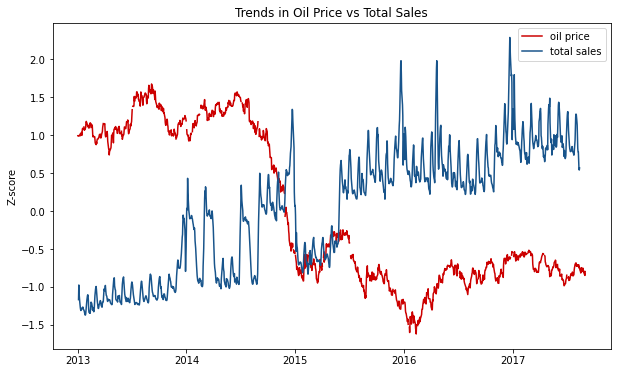

In [5]:
fig = plt.figure(figsize=(10,6))
norm_oil = (oil_df.dcoilwtico - oil_df.dcoilwtico.mean()) / oil_df.dcoilwtico.std()
plt.plot(oil_df.date,norm_oil, label='oil price')

total_sales = train_df.groupby('date').sum()
norm_ts = (total_sales.sales - total_sales.sales.mean()) / total_sales.sales.std()
norm_ts_smooth = norm_ts.rolling(
    window=7,
    center=True
).mean()
    
plt.plot(norm_ts_smooth.index, norm_ts_smooth, label='total sales')
plt.legend()
plt.title('Trends in Oil Price vs Total Sales')
plt.ylabel('Z-score');

It looks like total sales is fairly independent from the oil price.

Now I'll briefly look into transactions:

In [6]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [7]:
transactions_df.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [8]:
train_df.loc[(train_df.date=='2017-08-15') & (train_df.store_nbr==50),'sales'].sum()

16879.121004

In [9]:
transactions_df.transactions.corr(train_df.groupby('store_nbr').sum().sales)

0.2586906981299479

So what I've established here is:
- the transactions only go up to 08/15 (the end of the train data) so I'd have to predict them too if I want to use them to predict sales
- transactions and sales are **not** the same
- transactions and sales are not highly correlated

My conclusion, following the trend so far, is to ignore this extra dataframe.

In [10]:
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [11]:
holiday_df.description.value_counts()

Carnaval                              10
Fundacion de Cuenca                    7
Fundacion de Ibarra                    7
Fundacion de Quito                     6
Provincializacion de Santo Domingo     6
                                      ..
Terremoto Manabi+8                     1
Recupero puente Navidad                1
Terremoto Manabi+10                    1
Terremoto Manabi+11                    1
Traslado Fundacion de Quito            1
Name: description, Length: 103, dtype: int64

In [12]:
holiday_df[(holiday_df.date > '2017-08-14') & (holiday_df.date < '2017-08-31')]

,date,type,locale,locale_name,description,transferred
326,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


Looks like there aren't many holidays in the time period we aim to predict. Does this mean I can eschew holidays alltogether? No. Take a look at the actual time series of total sales:

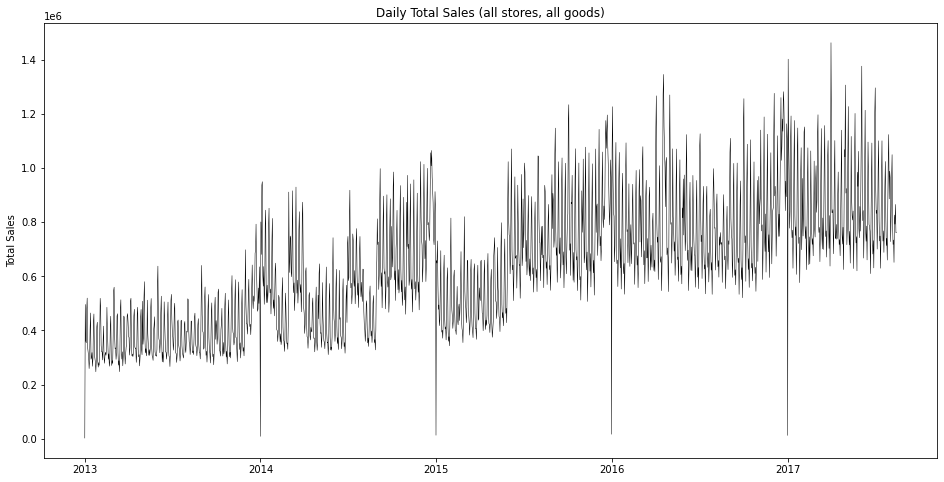

In [13]:
fig = plt.figure(figsize=(16,8))
plt.plot(total_sales.index,total_sales.sales,c='k',linewidth=0.5)
plt.title('Daily Total Sales (all stores, all goods)')
plt.ylabel('Total Sales');

There are huge spikes showing when stores are closed on el primer día del año. While other holiday effects invisible to the naked eye may or may not exist, the best way to quantify them, in my opinion, is by looking at the coefficients of the linear regression for this time series *with* holidays included.

I know from the data description, however, that there are shenanigans in the holiday_df that need to be dealt with before I encode them for the purpose stated above:

>NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

I also know that for this proof of concept I'll only consider national holidays.

In [14]:
holiday_df.set_index(holiday_df.date, inplace=True)

So what I want is:

In [15]:
nacional = holiday_df[(holiday_df.locale == 'National') & (holiday_df.transferred == False)].copy()
nacional.description = nacional.description.str.replace(r'Traslado ', '')
nacional = pd.get_dummies(nacional.description)
nacional

,Batalla de Pichincha,Black Friday,Carnaval,Cyber Monday,Dia de Difuntos,Dia de la Madre,Dia de la Madre-1,Dia del Trabajo,Inauguracion Mundial de futbol Brasil,Independencia de Cuenca,...,Terremoto Manabi+29,Terremoto Manabi+3,Terremoto Manabi+30,Terremoto Manabi+4,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2012-08-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-11-02,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-11-03,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-12-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And then it gets merged with total sales, so that the variables can be made.

Though, before merging, it should be noted that the additional step of forcing total sales to have daily frequency must take place. Time series can be deceptive by having "no NAs" when, in reality, there are entire days missing. In this case, it's navidad.

In [16]:
total_sales_H = pd.merge(total_sales, nacional, left_index=True, right_index=True, how='left')
total_sales_H = total_sales_H.loc[~total_sales_H.index.duplicated()] # smh

This introduces a mess of NAs into the dataframe. Fortunately, given the actual meaning of these NAs, they can all just be set to 0. Also, for current purposes, id and store_nbr are meaningless / not needed.

In [17]:
for col in total_sales_H.columns:
    total_sales_H.loc[total_sales_H[col].isna() == True, col] = 0

total_sales_H.drop(columns = ['id','store_nbr'], inplace=True)

## Trend

With the wide variety of data explored and appropriately incorporated or disregarded, now it's time for the main portion of the analysis, the time series portion.

Time series can be thought of as containing 4 fundamental elements: trend, seasonality, cycle, and error. The first of these, trend, is modeled as a simple function, such as a line, quadratic, or exponential curve. In this case, I think a line is probably fine.

In [18]:
dp = DeterministicProcess(
    index=total_sales_H.index,
    constant=True,
    order=1,  
    drop=True,   
)

X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


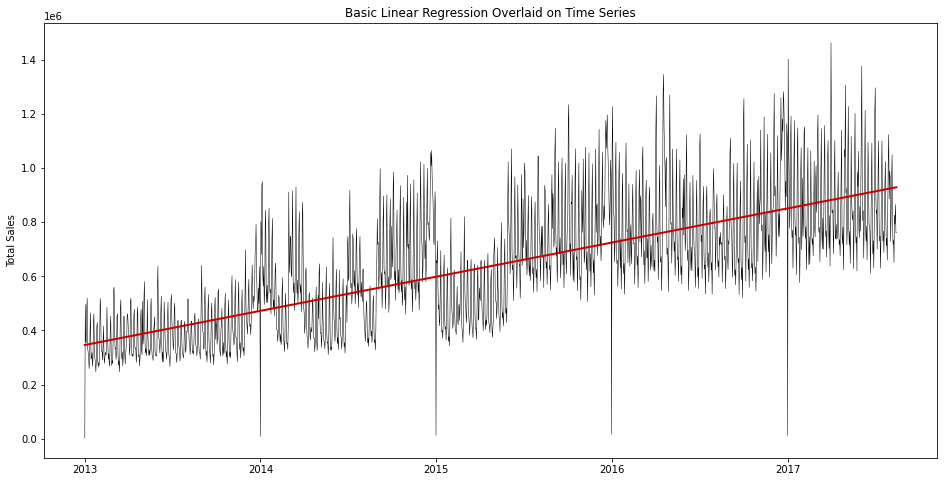

In [19]:
y = total_sales_H["sales"]  # the target
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
fig = plt.figure(figsize=(16,8))
plt.plot(total_sales_H.index,total_sales_H.sales,c='k',linewidth=0.5)
plt.plot(y_pred.index,y_pred,linewidth=2)
plt.title('Basic Linear Regression Overlaid on Time Series')
plt.ylabel('Total Sales');

In [20]:
mean_squared_log_error(y,y_pred, squared=False)

0.33268686935046055

Seems about right.

## Seasonality

Seaonality can be tackled in two ways, using indicator variables, and using fourier transforms to engineer cyclically oscillating features. To determine which methods ought to be used and how, a periodogram is useful.

The following function (which I did not write) plots a periodogram nicely:

In [21]:
def plot_periodogram(ts, detrend='linear', ax=None):

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104, 208])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "Bidaily (208)"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

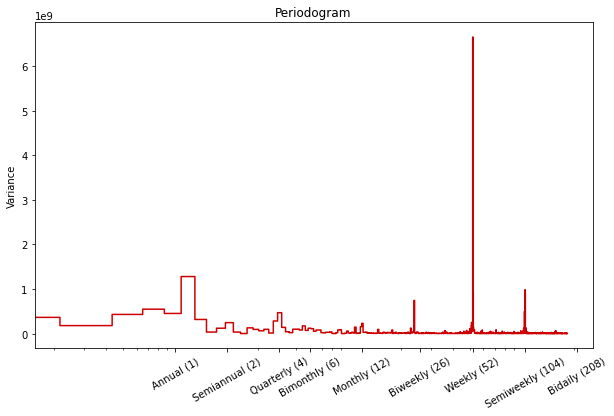

In [22]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
plot_periodogram(total_sales_H.sales, ax = ax);

By looking at the peaks of the periodogram, one is able to identify good frequencies for seasonal variables. Thinking ahead to the final model, which will have to loop through 1700 different time series, however, the question of automation arises. What *is* a periodogram? Can I have the computer look at it for me?

Underneath the graph, there are numerical values indicating where the peaks ought to be. These can be obtained with the periodgram function, like so:

In [23]:
freqs, spect = periodogram(
    total_sales_H.sales,
    fs = pd.Timedelta("365D") / pd.Timedelta("1D"),
    detrend='linear',
    window="boxcar",
    scaling='spectrum'
)

Where `freqs` is the frequency like 1 for annual, 52 for weekly, etc and `spect` is the "spectrum", or the variance used to determine the height of the periodogram. Using these values, I can automatically generate the fourier terms I want, and the weekly indicator for seasonality, if application (which it very much is for total sales, but you never know for individual family/store combos).

In [24]:
additional_terms = [] # a list to pass to DeterministicProcess
mo = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 12))) # monthly peaks
mo = mo[(mo < 4) & (mo > 0)] # specifically monthly
for i in mo:
    # generate monthly Fourier terms
    fourier = CalendarFourier(freq='M', order=i)
    additional_terms.append(fourier)
    
yr = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 1)))
yr = yr[(yr < 12) & (yr > 0)]
for i in yr:
    fourier = CalendarFourier(freq='A', order=i)
    additional_terms.append(fourier)

wk = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 52)))
wk = wk[(wk < 7) & (wk > 0)]
for i in wk:
    if i == 1:
        term = Seasonality(period=7) # indicator
    else:
        term = CalendarFourier(freq='W', order=i) # other weekly Fourier terms
    additional_terms.append(term)

In [25]:
additional_terms

[Fourier(freq=M, order=1) at 0x1b08393fb20,
 Fourier(freq=M, order=2) at 0x1b08393f430,
 Fourier(freq=A-DEC, order=1) at 0x1b083ae7700,
 Fourier(freq=A-DEC, order=2) at 0x1b083927df0,
 Fourier(freq=A-DEC, order=3) at 0x1b083b769b0,
 Fourier(freq=A-DEC, order=4) at 0x1b083b77730,
 Seasonality(period=7) at 0x1b083b61c00,
 Fourier(freq=W-SUN, order=2) at 0x1b083b760b0]

And so it is clear that this process captured all of the seasonality-related terms I would have thought of by just looking at the periodogram. Now let's pass this to the deterministic process and then see how the new model does.

In [26]:
dp = DeterministicProcess(
    index=total_sales_H.index,
    constant=True,
    order=1,   
    additional_terms=additional_terms, 
    drop=True,
)

X = dp.in_sample()

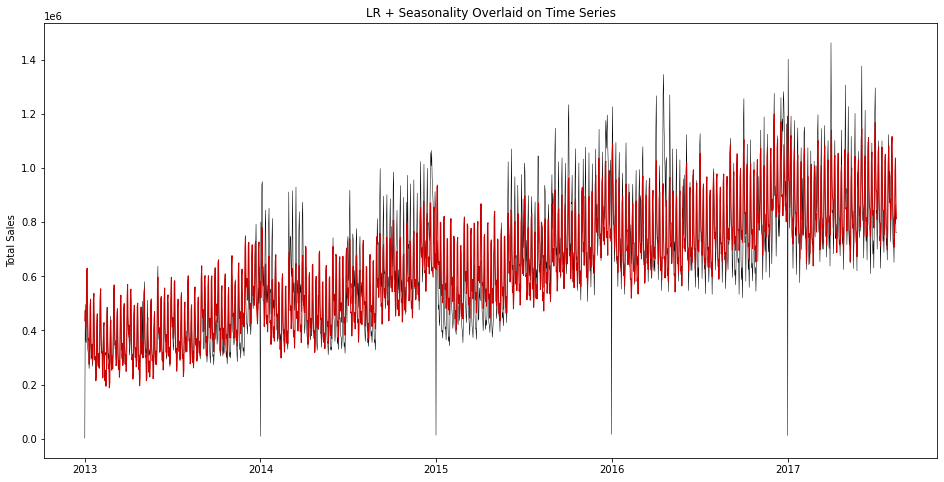

In [27]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred[y_pred < 0] = 0
fig = plt.figure(figsize=(16,8))
plt.plot(y.index,y,c='k',linewidth=0.5)
plt.plot(y_pred.index,y_pred,linewidth=1)
plt.title('LR + Seasonality Overlaid on Time Series')
plt.ylabel('Total Sales');

In [28]:
mean_squared_log_error(y,y_pred, squared=False)

0.28430773100960116

At this point, I also realize I should have included the holidays as well.

In [29]:
X = pd.merge(X, total_sales_H[nacional.columns], left_index=True, right_index=True, how='left')

In [30]:
X

,const,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","sin(1,freq=A-DEC)","cos(2,freq=A-DEC)",...,Terremoto Manabi+29,Terremoto Manabi+3,Terremoto Manabi+30,Terremoto Manabi+4,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,2.0,0.201299,0.979530,0.394356,0.918958,0.999852,0.034422,0.017213,0.999407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,3.0,0.394356,0.918958,0.724793,0.688967,0.999407,0.068802,0.034422,0.997630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,4.0,0.571268,0.820763,0.937752,0.347305,0.998667,0.103102,0.051620,0.994671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,5.0,0.724793,0.688967,0.998717,-0.050649,0.997630,0.137279,0.068802,0.990532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.897805,-0.440394,-0.790776,-0.612106,-0.777597,0.977848,-0.628763,0.209315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,1.0,1681.0,0.790776,-0.612106,-0.968077,-0.250653,-0.766659,0.984474,-0.642055,0.175531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,1682.0,0.651372,-0.758758,-0.988468,0.151428,-0.755493,0.989932,-0.655156,0.141540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


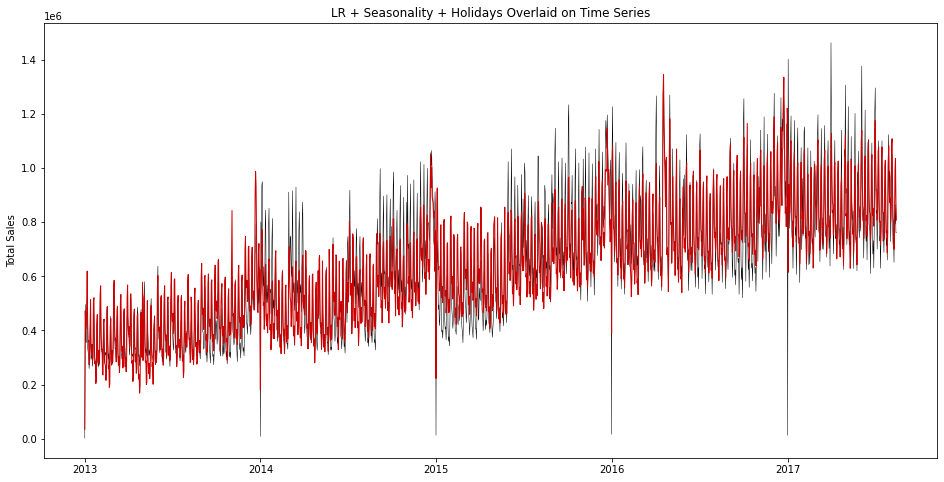

In [31]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred[y_pred < 0] = 0
fig = plt.figure(figsize=(16,8))
plt.plot(y.index,y,c='k',linewidth=0.5)
plt.plot(y_pred.index,y_pred,linewidth=1)
plt.title('LR + Seasonality + Holidays Overlaid on Time Series')
plt.ylabel('Total Sales');

In [32]:
mean_squared_log_error(y,y_pred, squared=False)

0.23184018477607687

While Holidays hasn't made it perfect, it certainly made it better.

## Cycle

Cyclical elements are like irregular seasonality. The way to capture these is via lag features. There are two features I will determine if there ought to be lags for, `sales` (the target feature itself) and `onpromotion`.

A good way to understand which lag features to select is by examining their partial autocorrelation with the target variable.

Note also, that this cycle-analyzing work is done after removing the seasonality and trend from the data. I call this variable `y_bland` because its been de-**seasoned**.

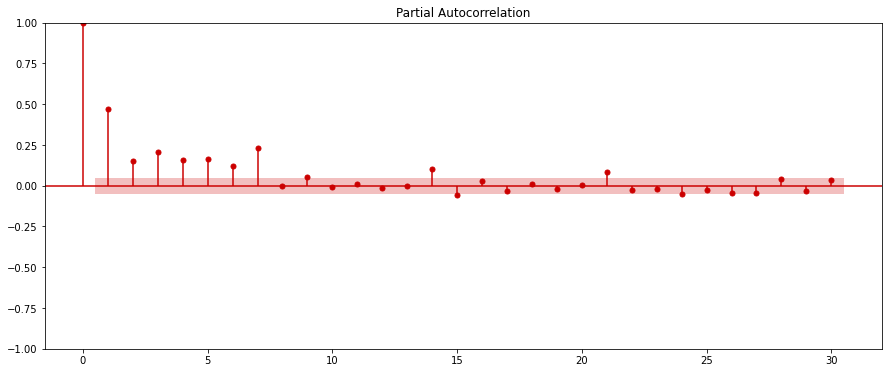

In [33]:
y_bland = y - y_pred
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
plot_pacf(y_bland, method='ywm', lags=30, ax = ax);

By looking at this plot and seeing which lag features extend outside of the 95% confidence interval (the shaded region) I can decide which ones to analyze further and use as features.

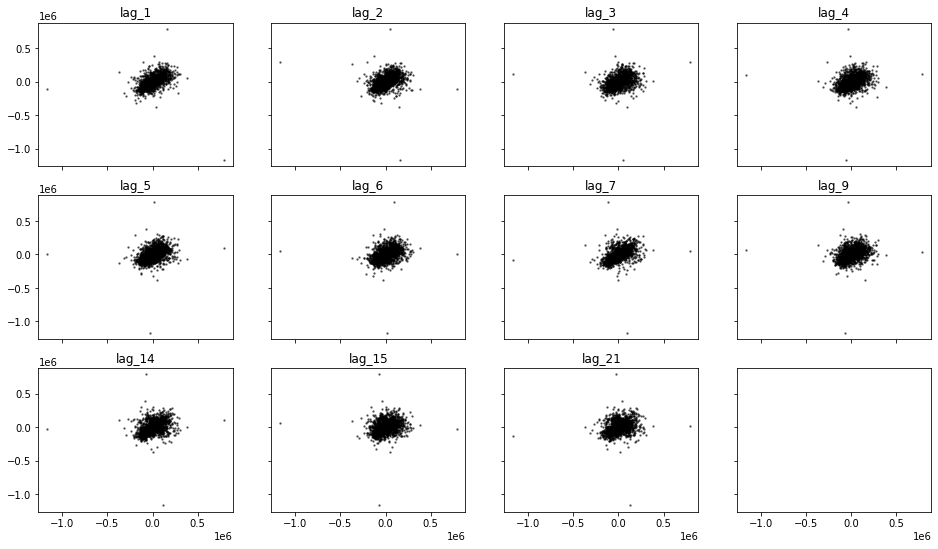

In [34]:
fig, ax = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(16,9))
k = [1,2,3,4,5,6,7,9,14,15,21]
for i in range(3):
    for j in range(4):
        try:
            ax[i, j].scatter(y_bland,y_bland.shift(k[i*4+j]), c='k',s=2,alpha=0.5)
            ax[i, j].set_title(f'lag_{k[i*4+j]}')
        except IndexError:
            continue

As expected, these are only weak to moderate correlations, but they'll still be relevant to building the model.

Let's examine the `onpromotion` feature. Since it's the correlation between it and the target we're concerned with, we can't use the nice autocorrelation plot first, and have to examine the relevant lag plots instead.

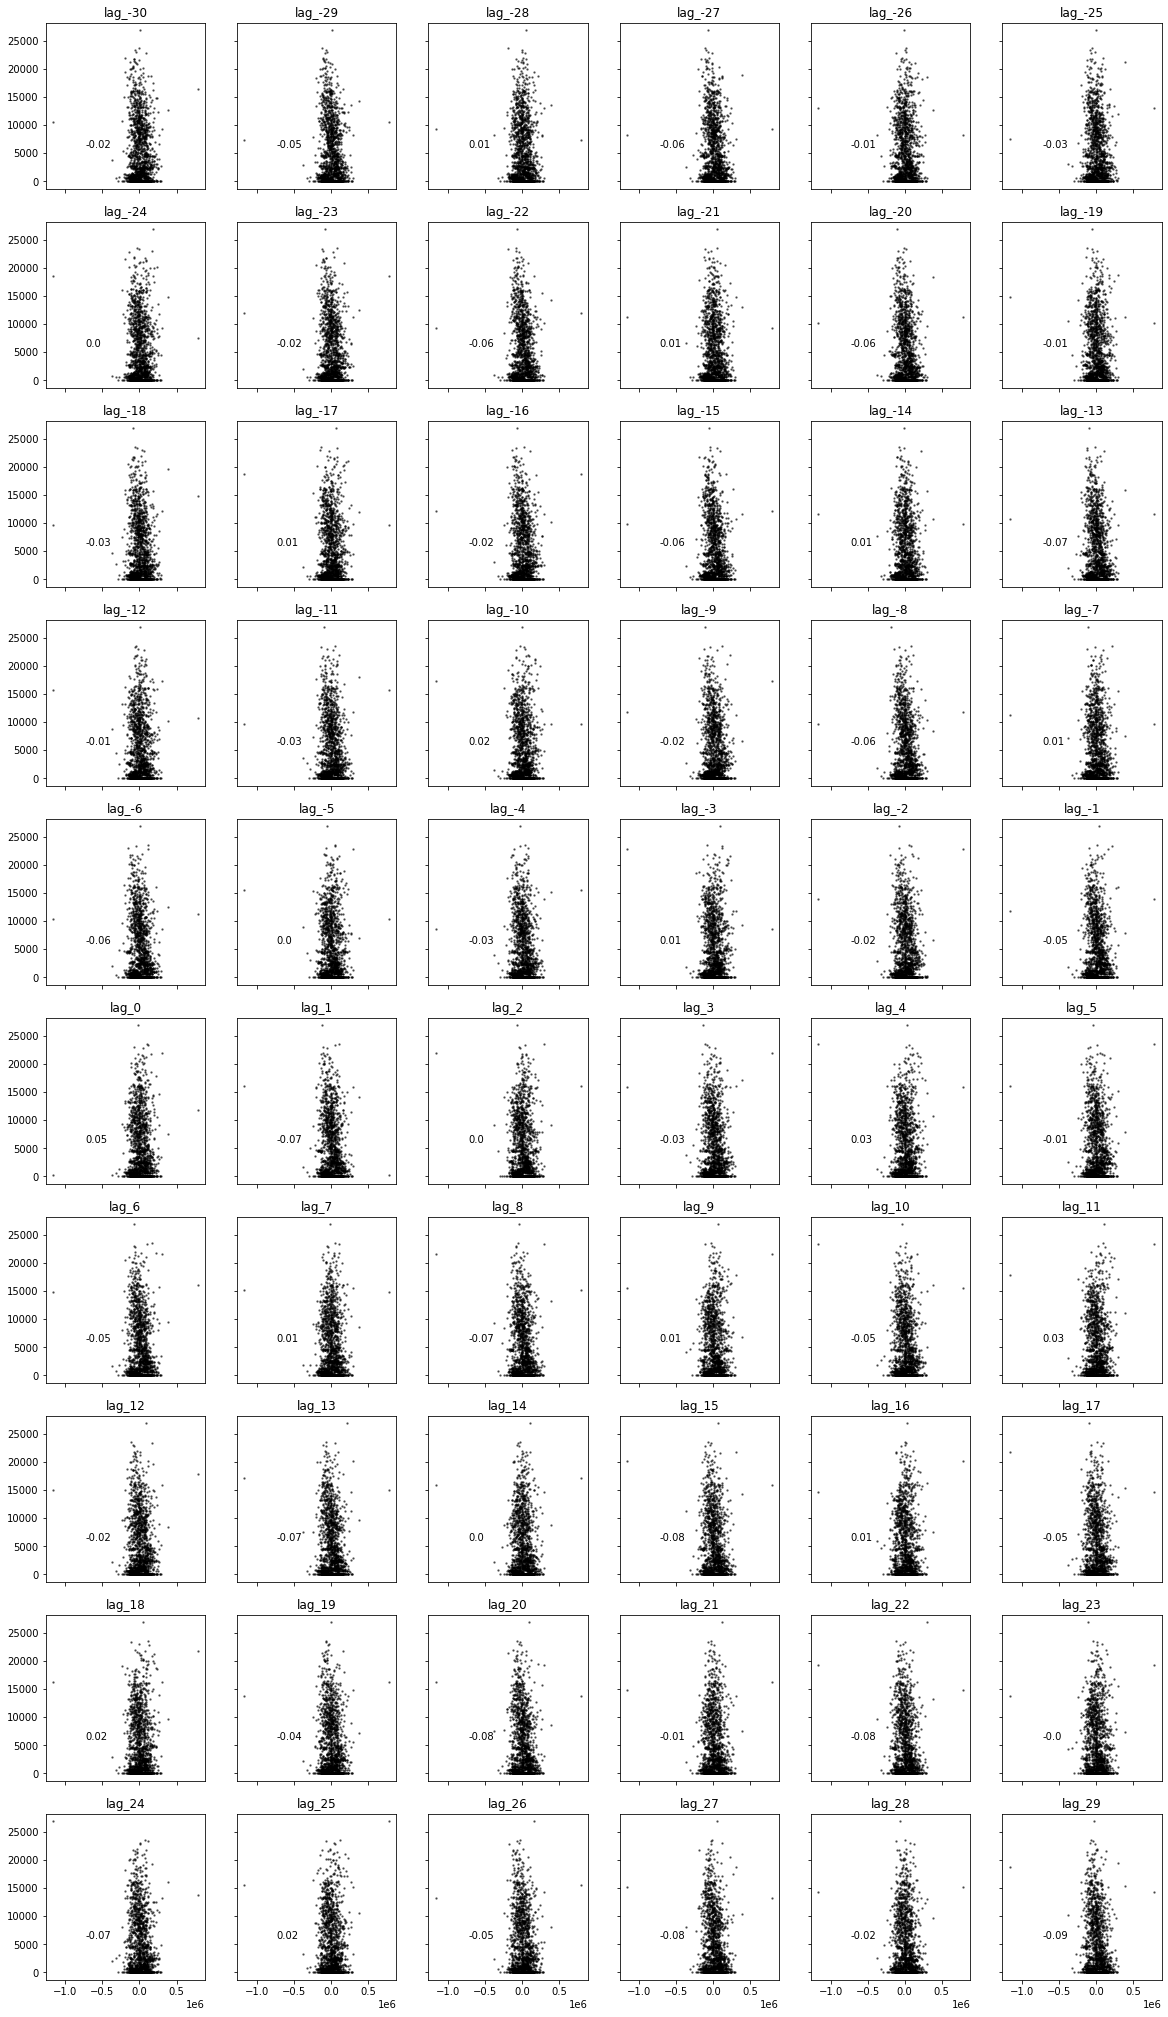

In [35]:
fig, ax = plt.subplots(10, 6, sharex='col', sharey='row', figsize=(20,36))
k = np.arange(-30,30)
for i in range(10):
    for j in range(6):
        try:
            ax[i, j].scatter(y,total_sales.onpromotion.shift(k[i*6+j]), c='k',s=2,alpha=0.5)
            ax[i, j].set_title(f'lag_{k[i*6+j]}')
            ax[i, j].text(0.25,0.25,np.round(y_bland.corr(total_sales.onpromotion.shift(k[i*6+j])),2),transform=ax[i,j].transAxes)
        except IndexError:
            continue

After this exhaustive search, I conclude that I don't actually care about the `onpromotion` feature after all.

Let's see how the model does now.

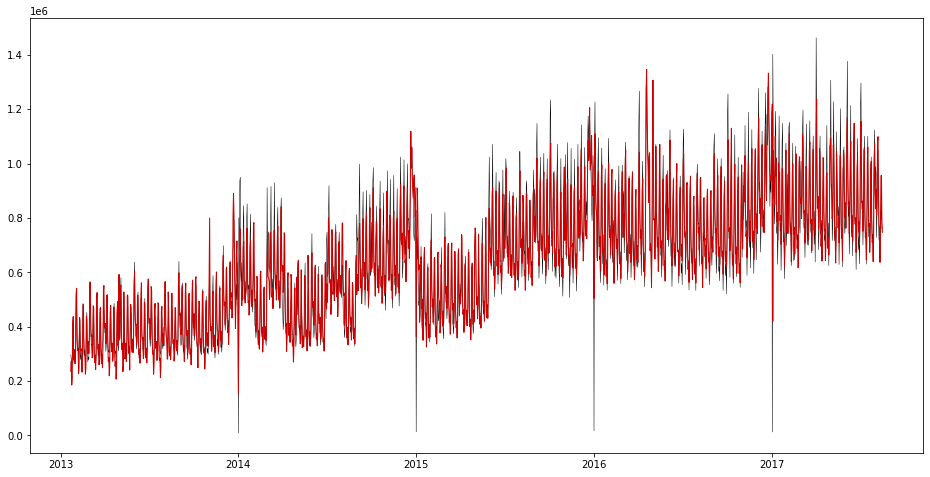

In [36]:
k = [1,2,3,4,5,6,7,9,14,15,21]
for i in k:
    X[f'lag_{i}'] = y.shift(i)
y = y.drop(y[X.isna().sum(axis=1) != 0].index)
X.dropna(inplace=True)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
fig = plt.figure(figsize=(16,8))
plt.plot(y.index,y,c='k',linewidth=0.5)
plt.plot(y_pred.index,y_pred,linewidth=1);

In [37]:
mean_squared_log_error(y,y_pred, squared=False)

0.20446670065163514

Continued improvement has been achieved.

## Residuals

With the trend, seasonality, and cycle extracted from the data and holidays accounted for, all that's left now is the residual:

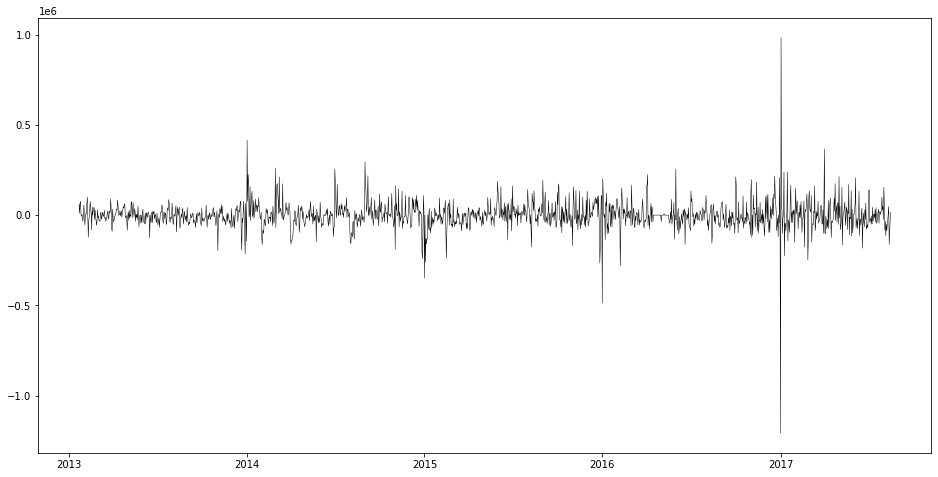

In [38]:
y_blander = y - y_pred
fig = plt.figure(figsize=(16,8))
plt.plot(y_blander.index,y_blander,c='k',linewidth=0.5);

This is pretty much random, which is what we want. I do notice very clearly here that despite *primer día del año* being *traslado* in 2017, the business was still evidently closed on the actual 1st and thus the model drastically underestimates the 2nd and drastically overestimates the 1st for that year. I'll correct this when I create a process for generating the holidays for each family/store combination.

It is alleged by the machine learning community that you can simply fit a model to the residual and this will improve the overall predictive power. Accepting this assertion I do this with XGB below:

In [39]:
resid_model = xgb.XGBRegressor()
resid_model.fit(X, y_blander)
hybrid_y_pred = resid_model.predict(X) + y_pred
mean_squared_log_error(y,hybrid_y_pred, squared=False)

0.013497956176398537

# Testing

Armed with a means of fitting models to the training data automatically, I'm now left to put this all together in a way that can readily handle any of the 1700 family/store combinations. To do so, I'll test everything on an individual slice.

In [45]:
train_slice = train_df[(train_df.store_nbr == 1) & (train_df.family == 'GROCERY I')].copy()
train_slice.set_index(train_slice.date, inplace=True)
train_slice = train_slice.asfreq('d')
train_slice.loc[train_slice.id.isna() == True, 'sales'] = 0

test_slice = test_df[(test_df.store_nbr == 1) & (test_df.family == 'GROCERY I')].copy()
test_slice.set_index(test_slice.date, inplace=True)
test_slice = test_slice.asfreq('d')

Time series steps, are almost exactly the same as before, since they are engineered for this purpose.

In [46]:
freqs, spect = periodogram(
    train_slice.sales,
    fs = pd.Timedelta("365D") / pd.Timedelta("1D"),
    detrend='linear',
    window="boxcar",
    scaling='spectrum'
)

In [47]:
additional_terms = []
mo = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 12)))
mo = mo[(mo < 4) & (mo > 0)]
for i in mo:
    fourier = CalendarFourier(freq='M', order=i)
    additional_terms.append(fourier)
    
yr = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 1)))
yr = yr[(yr < 12) & (yr > 0)]
for i in yr:
    fourier = CalendarFourier(freq='A', order=i)
    additional_terms.append(fourier)

wk = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 52)))
wk = wk[(wk < 7) & (wk > 0)]
for i in wk:
    if i == 1:
        term = Seasonality(period=7)
    else:
        term = CalendarFourier(freq='W', order=i)
    additional_terms.append(term)

In [48]:
dp = DeterministicProcess(
    index=train_slice.index,
    constant=True,
    order=1,   
    additional_terms=additional_terms, 
    drop=True,
)

X = dp.in_sample()

Holidays gets a little more complicated because I want to add local ones and make sure I handle transferred ones more accurately.

In [49]:
holiday_df.locale_name.unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [50]:
stores_df.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [51]:
stores_df.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

It appears that the "locale" names in holiday_df are a mix of city and state names.

In [52]:
locales = holiday_df.locale_name.unique()
states = stores_df.state.unique()
cities = stores_df.city.unique()

b = 0
s = 0
c = 0

for lug in locales:
    if lug in states and lug in cities:
        b += 1
    elif lug in states:
        s += 1
    elif lug in cities:
        c += 1
    else:
        continue
        
print(f'both:{b}\nstate:{s}\ncity:{c}')
    

both:2
state:4
city:17


Alright, so it can check cities first and then states

In [53]:
store_city = stores_df.loc[stores_df.store_nbr == 1,'city'].iloc[0]
store_city

'Quito'

In [54]:
store_state = stores_df.loc[stores_df.store_nbr == 1,'state'].iloc[0]
store_state

'Pichincha'

In [55]:
relevant_holidays = holiday_df[
    (holiday_df.locale_name == 'Ecuador')
    | (holiday_df.locale_name == store_city)
    | (holiday_df.locale_name == store_state)
]

In [56]:
relevant_holidays = pd.get_dummies(relevant_holidays.description)
relevant_holidays

,Batalla de Pichincha,Black Friday,Carnaval,Cyber Monday,Dia de Difuntos,Dia de la Madre,Dia de la Madre-1,Dia del Trabajo,Fundacion de Quito,Fundacion de Quito-1,...,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Fundacion de Quito,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2012-08-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2012-11-02,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-11-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X = pd.merge(X, relevant_holidays, left_index=True, right_index=True, how='left')

X = X.loc[~X.index.duplicated()]
for col in X.columns:
    X.loc[X[col].isna() == True, col] = 0

Now for the lags

In [58]:
# 1st model, to deseason
y = train_slice['sales']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred[y_pred < 0] = 0

In [59]:
# make lags
y_resid = y - y_pred
pacf_val, ci = pacf(y_resid, 30, alpha=0.05)
lags = np.arange(31)[(pacf_val >= 0.05)]
lags = lags[lags !=0]

for i in lags:
    X[f'lag_{i}'] = y.shift(i)

y = y.drop(y[X.isna().sum(axis=1) != 0].index)
X.dropna(inplace=True)

And the linear model can be fit to the training set:

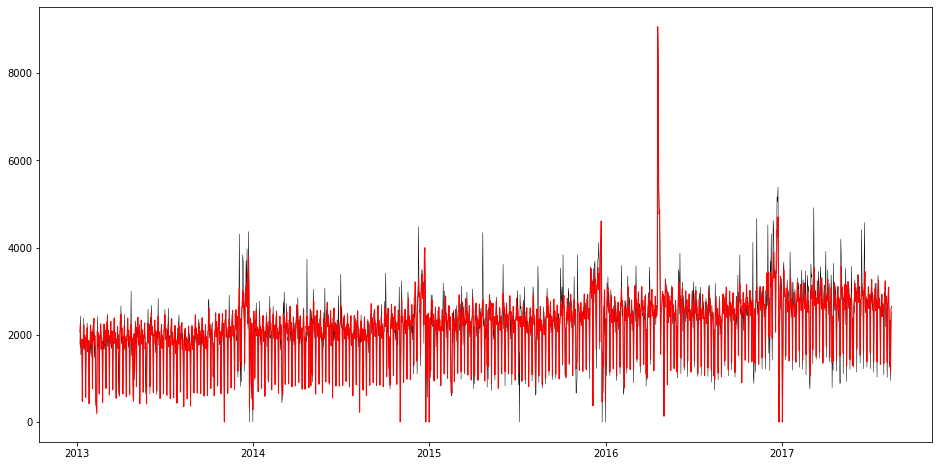

In [60]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred2 = pd.Series(model.predict(X), index=X.index)
y_pred2[y_pred2 < 0] = 0
fig = plt.figure(figsize=(16,8))
plt.plot(y.index,y,c='k',linewidth=0.5)
plt.plot(y_pred2.index,y_pred2,c='r',linewidth=1);

In [61]:
mean_squared_log_error(y,y_pred2, squared=False)

0.4528349520428165

A little higher than on the overall one, but that's to be expected.

Now, in order to actually make all 15 predictions required by the competition, we'll need to rely on recursive modeling, due to the presence of lag features. (how do I have lag_1 for 14 days in the future without having sales information from 13 days in the future?) That's what I do below:

In [62]:
y_copy = y.copy()

test_X = X.copy()

for i in range(len(test_slice.index)):

    current_test_X = dp.range(test_slice.index[i],test_slice.index[i])

    current_test_X = pd.merge(current_test_X,
                              relevant_holidays,
                              left_index=True,
                              right_index=True,
                              how='left')

    current_test_X = current_test_X.loc[~current_test_X.index.duplicated(),
                                        ~current_test_X.columns.duplicated()]
    # current_test_X = current_test_X[X.columns]
    for col in current_test_X.columns:
        current_test_X.loc[current_test_X[col].isna() == True, col] = 0
    
    for j in lags:
        current_test_X[f'lag_{j}'] = y_copy[-j]
        

    
    test_X = pd.concat([test_X,current_test_X])
    
    single_y_pred = pd.Series(model.predict(current_test_X), index = current_test_X.index)
    y_copy = pd.concat([y_copy, single_y_pred])
                              
y_pred = y_copy[test_slice.index]
y_pred.name = 'sales'

test_X = test_X.loc[test_slice.index]

In [63]:
y_pred

date
2017-08-16    3041.597529
2017-08-17    2547.969760
2017-08-18    2838.340039
2017-08-19    2674.983585
2017-08-20    1377.514172
2017-08-21    2693.146126
2017-08-22    2684.717829
2017-08-23    2989.741838
2017-08-24    2421.647547
2017-08-25    2652.509723
2017-08-26    2490.080165
2017-08-27    1233.644096
2017-08-28    2616.545454
2017-08-29    2698.821597
2017-08-30    3108.974812
2017-08-31    2642.626071
Name: sales, dtype: float64

With that taken care of, the last step is to combine this process of predicting the actual test data points recursively with all of the preprocessing and  XGB regressions all into one thing that can loop over the 1,782 different time series.

# Production

In [72]:
def final_model2(train_df,test_df, holiday_df, stores_df):
    predictions = []
    
    # do the entire process for each store/family combo
    for nbr in progressbar(train_df.store_nbr.value_counts().index.values):
        for fam in train_df.family.value_counts().index.values:
        
            # make this iterations train and test slices
            train_slice = train_df[(train_df.store_nbr == nbr) & (train_df.family == fam)].copy()
            train_slice.set_index(train_slice.date, inplace=True)
            train_slice = train_slice.asfreq('d')
            
            test_slice = test_df[(test_df.store_nbr == nbr) & (test_df.family == fam)].copy()
            test_slice.set_index(test_slice.date, inplace=True)
            test_slice = test_slice.asfreq('d')
            
            # no data for some days smh mh
            train_slice.loc[train_slice.id.isna() == True, 'sales'] = 0
            
            if train_slice.sales.sum() == 0:
                test_slice['sales'] = 0
                predictions.append(test_slice[['id','sales']])
            
            else:

                # generate periodogram
                freqs, spect = periodogram(
                    train_slice.sales,
                    fs = pd.Timedelta("365D") / pd.Timedelta("1D"),
                    detrend='linear',
                    window="boxcar",
                    scaling='spectrum'
                )

                # extract yearly, monthly, and weekly terms from periodogram 
                additional_terms = []
                mo = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 12)))
                mo = mo[(mo < 4) & (mo > 0)]
                for i in mo:
                    fourier = CalendarFourier(freq='M', order=i)
                    additional_terms.append(fourier)

                yr = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 1)))
                yr = yr[(yr < 12) & (yr > 0)]
                for i in yr:
                    fourier = CalendarFourier(freq='A', order=i)
                    additional_terms.append(fourier)

                wk = np.array(list(set(freqs[spect >= (np.quantile(spect,0.98))] // 52)))
                wk = wk[(wk < 7) & (wk > 0)]
                for i in wk:
                    if i == 1:
                        term = Seasonality(period=7)
                    else:
                        term = CalendarFourier(freq='W', order=i)
                    additional_terms.append(term)

                # create trend + seasonality features
                dp = DeterministicProcess(
                    index=train_slice.index,
                    constant=True,
                    order=1,   
                    additional_terms=additional_terms, 
                    drop=True,
                )

                train_X = dp.in_sample()
                train_y = train_slice['sales'] # train_y
                
                # holidays
                holiday_df.set_index(holiday_df.date, inplace=True)
                store_city = stores_df.loc[stores_df.store_nbr == nbr,'city'].iloc[0]
                store_state = stores_df.loc[stores_df.store_nbr == nbr,'state'].iloc[0]
                relevant_holidays = holiday_df[
                    (holiday_df.locale_name == 'Ecuador')
                    | (holiday_df.locale_name == store_city)
                    | (holiday_df.locale_name == store_state)
                ]
                relevant_holidays = pd.get_dummies(relevant_holidays.description)
                train_X = pd.merge(train_X, relevant_holidays, left_index=True, right_index=True, how='left')
                train_X = train_X.loc[~train_X.index.duplicated()]
                for col in train_X.columns:
                    train_X.loc[train_X[col].isna() == True, col] = 0

                # first linear regression to be able to identify lags
                LR1_seas = LinearRegression(fit_intercept=False,n_jobs=10)
                LR1_seas.fit(train_X, train_y)

                y_seas = pd.Series(LR1_seas.predict(train_X), index=train_X.index)
                y_seas[y_seas < 0] = 0 
                y_deseason = train_y - y_seas

                # partial autocorrelation
                pacf_res, ci = pacf(y_deseason, 30, alpha=0.05)

                # lag identification
                lags = np.arange(31)[(pacf_res >= 0.05)]
                lags = lags[lags !=0]

                for i in lags: # and creation
                    train_X[f'lag_{i}'] = train_y.shift(i)

                # drop created NAs
                train_y = train_y.drop(train_y[train_X.isna().sum(axis=1) != 0].index)
                train_X.dropna(inplace=True)

                # this will be used later...
                LR2_lags = LinearRegression(fit_intercept=False,n_jobs=10)
                LR2_lags.fit(train_X, train_y)
                old_yhat = pd.Series(LR2_lags.predict(train_X), index=train_X.index)
                old_yhat[old_yhat < 0] = 0

                # now we predict out with LR2 to the appropriate point in test
                # for later use.

                y_copy = train_y.copy()

                test_X = train_X.copy()

                for i in range(len(test_slice.index)):

                    current_test_X = dp.range(test_slice.index[i],test_slice.index[i])
                    
                    current_test_X = pd.merge(current_test_X,
                              relevant_holidays,
                              left_index=True,
                              right_index=True,
                              how='left')

                    current_test_X = current_test_X.loc[~current_test_X.index.duplicated(),
                                                        ~current_test_X.columns.duplicated()]
                    # current_test_X = current_test_X[X.columns]
                    for col in current_test_X.columns:
                        current_test_X.loc[current_test_X[col].isna() == True, col] = 0

                    for j in lags:
                        current_test_X[f'lag_{j}'] = y_copy[-j]

                    test_X = pd.concat([test_X,current_test_X])

                    single_y_pred = pd.Series(LR2_lags.predict(current_test_X), index = current_test_X.index)
                    y_copy = pd.concat([y_copy, single_y_pred])

                # very important steps    
                y_pred = y_copy[test_slice.index].copy()
                y_pred.name = 'sales'

                test_X = test_X.loc[test_slice.index].copy() 

                # fit model to residuals
                old_y_resid = train_y - old_yhat

                XGB = xgb.XGBRegressor(n_jobs=10)

                XGB.fit(train_X,old_y_resid)

                y_pred = XGB.predict(test_X) + y_pred

                # re-associate with IDs so submission is correctly formatted.
                predictions.append(pd.merge(test_slice, y_pred, left_index=True, right_index=True)[['id','sales']])
            
    predictions = pd.concat(predictions)
    return predictions

In [73]:
pred2 = final_model2(train_df,test_df, holiday_df, stores_df)

100% (54 of 54) |########################| Elapsed Time: 0:26:20 Time:  0:26:20


In [74]:
pred2.to_csv('./test_submission2.csv', index=False)

I'm sure there are many things I could do to improve the runtime of this function, but seeing as it is in the context of an unpaid project I'm doing for fun in my free time, I think it's fine that it took half an hour and I could go eat breakfast. I embarked on this project with a very specific goal: beating the horde of people who had copy-pasted someone's shared notebook which got a score of 0.5109 for this challenge, and I have achieved this goal. I also completed a five hour course on time series analysis, so that I could shore up my knowledge in this topic area, which was its own reward.